In [4]:
from torch.utils.data import Dataset, DataLoader
from torch.nn import functional as F
from torch import nn, optim

import matplotlib.pyplot as plt
import scipy.signal
import numpy as np
import torch

import random
%matplotlib inline

In [5]:
# Define our bandpass filter
def butter_bandpass_filter(data, lowcut, highcut, fs, order):
        nyq = 0.5 * fs  # sampling rate (fs)
        low = lowcut / nyq
        high = highcut / nyq
        sos = scipy.signal.butter(order, [low, high], analog=False, btype='band', output='sos')

        y = scipy.signal.sosfilt(sos, data)
        
        return y

In [6]:
import pandas as pd
import csv

# Datastamp | timestamp | Marker | EEG Channels (20)
# Marker 기준으로 자르기
dataset_unfiltered_Marker1 = []
dataset_unfiltered_Marker2 = []

block = []
prev = '-1'
f = open('../Random Sample Data (10m).csv', 'r', encoding='utf-8')
rdr = csv.reader(f)
next(rdr)

for line in rdr:
    if line[2] is not prev:
        if prev == '1':
            dataset_unfiltered_Marker1.extend(block)
        elif prev == '2':
            dataset_unfiltered_Marker2.extend(block)
        block = []
        prev = line[2]
        
        if line[2] == 'end':
            break

    block.append(line)

f.close()

print(len(dataset_unfiltered_Marker1))
print(len(dataset_unfiltered_Marker2))

137008
140488


In [7]:
block = []
prev = '-1'
f = open('../Random Sample Data (15m).csv', 'r', encoding='utf-8')
rdr = csv.reader(f)
next(rdr)

for line in rdr:
    if line[2] is not prev:
        if prev == '1':
            dataset_unfiltered_Marker1.extend(block)
        elif prev == '2':
            dataset_unfiltered_Marker2.extend(block)
        block = []
        prev = line[2]
        
        if line[2] == 'end':
            break

    block.append(line)

f.close()

print(len(dataset_unfiltered_Marker1))
print(len(dataset_unfiltered_Marker2))

307459
311490


In [8]:
####################
#  Bandpass filter #
####################
dataset_unfiltered_Marker1 = np.array(dataset_unfiltered_Marker1)
dataset_unfiltered_Marker2 = np.array(dataset_unfiltered_Marker2)

dataset_unfiltered_Marker1 = dataset_unfiltered_Marker1.astype(np.float32)
dataset_unfiltered_Marker2 = dataset_unfiltered_Marker2.astype(np.float32)


overlap = 0.5
windowWidth = 256    # Set windows as 0.256s
sampleRate = 500
channelNum = 20


def filterData(unfilteredData):
    dataset_filtered = []

    for start in range(0, len(unfilteredData) - windowWidth, int(windowWidth / overlap)):
        filteredChannel = []
        window = []
        for channel in range(3, channelNum + 3):
            sample = butter_bandpass_filter(unfilteredData[start:start+windowWidth, channel], lowcut=5, highcut=50, fs=sampleRate, order=3)
            filteredChannel.append(sample)
        window.append(filteredChannel)
        dataset_filtered.append(window)

    dataset_filtered = np.vstack(dataset_filtered).astype(np.float32)

    return dataset_filtered

dataset_filtered_Marker1 = filterData(dataset_unfiltered_Marker1)
dataset_filtered_Marker2 = filterData(dataset_unfiltered_Marker2)

print(dataset_filtered_Marker1.shape)
print(dataset_filtered_Marker2.shape)

(601, 20, 256)
(608, 20, 256)


In [9]:
# Out Autoencoder Parameters
CUDA = True
SEED = 1
BATCH_SIZE = 32
LOG_INTERVAL = 8
EPOCHS = 400
EPOCHS_INTERVAL = 50
AE_PARAMS = 40
TRAINING_SET_SIZE = 0.8

CUDA_LAUNCH_BLOCKING=1

In [10]:
# Our custom Dataset class
class EEGDataset(Dataset):
    """EEG dataset."""
    def __init__(self, data_np):
        self.data = data_np
        
    def __len__(self):      
        return len(self.data)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        return self.data[idx, :]

In [11]:
# Instantiate the dataset, and create training and test data sets
dataset_filtered = np.concatenate((dataset_filtered_Marker1, dataset_filtered_Marker2), axis=0)
print(dataset_filtered.shape)
full_dataset = EEGDataset(dataset_filtered)

train_size = int(TRAINING_SET_SIZE * len(full_dataset))
test_size = int((len(full_dataset) - train_size)/2)
valid_size = len(full_dataset) - train_size - test_size

train_dataset, valid_dataset, test_dataset = torch.utils.data.random_split(full_dataset, [train_size, valid_size, test_size])

# the PyTorch DataLoader class handles randomization and feeding the Autencoder with data
train_loader = DataLoader(dataset=train_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=True,
                          num_workers=0)

valid_loader = DataLoader(dataset=valid_dataset,
                         batch_size=BATCH_SIZE,
                         shuffle=True,
                         num_workers=0)

test_loader = DataLoader(dataset=test_dataset,
                         batch_size=BATCH_SIZE,
                         shuffle=True,
                         num_workers=0)


(1209, 20, 256)


In [12]:
class Autoencoder(nn.Module):
    def __init__(self, ae_width):
        super(Autoencoder, self).__init__()

        self.fc1 = nn.Linear(256, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, ae_width)
        self.fc4 = nn.Linear(ae_width, 64)
        self.fc5 = nn.Linear(64, 128)
        self.fc6 = nn.Linear(128, 256)

    def encode(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

    def decode(self, x):
        x = F.relu(self.fc4(x))
        x = F.relu(self.fc5(x))
        return self.fc6(x)

    def forward(self, x):
        x = self.encode(x.view(-1, 256))
        return self.decode(x)

In [13]:
# Instantiate the Autoencoder
model = Autoencoder(AE_PARAMS)
model.cuda()
print(model)

Autoencoder(
  (fc1): Linear(in_features=256, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=40, bias=True)
  (fc4): Linear(in_features=40, out_features=64, bias=True)
  (fc5): Linear(in_features=64, out_features=128, bias=True)
  (fc6): Linear(in_features=128, out_features=256, bias=True)
)


(20, 256)


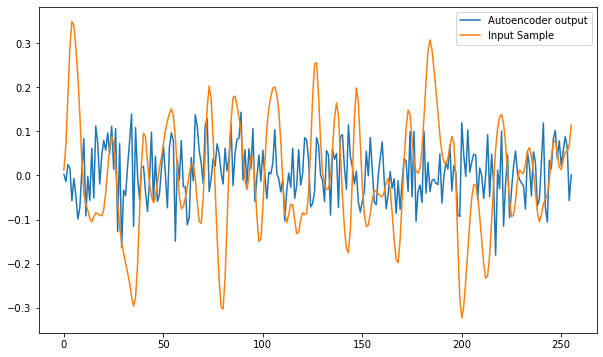

In [14]:
# Before Training, this is how well our Autoencoder can reconstruct the EEG data
print(full_dataset[1].shape)

with torch.no_grad():
    plt.figure(figsize=(10,6))
    x= model.encode(torch.from_numpy(full_dataset[1]).cuda()) 
    out = model.decode(x)
    out = out.cpu().detach().numpy()

    plt.plot(out[8], label='Autoencoder output') 
    plt.plot(full_dataset[1][8], label='Input Sample')
    plt.legend()

In [15]:
# Define how we optimizem, train, and test the Autoencoder
optimizer = optim.Adam(model.parameters(), lr=1e-4)

def train(epoch):
    model.train()
    train_loss = 0
    for batch_idx, data in enumerate(train_loader):
        data = data.cuda()
        optimizer.zero_grad()
        recon_batch = model(data)
        loss = F.mse_loss(recon_batch, data.view(-1, 256), reduction='sum')
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        if batch_idx % LOG_INTERVAL == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader),
                loss.item() / len(data)))

    print('====> Epoch: {} Average loss: {:.4f}'.format(
          epoch, train_loss / len(train_loader.dataset)))


def test(epoch):
    model.eval()
    test_loss = 0

    with torch.no_grad():
        for i, data in enumerate(test_loader):
            data = data.cuda()
            recon_batch = model(data)
            test_loss += F.mse_loss(recon_batch, data.view(-1, 256), reduction='sum')

    test_loss /= len(test_loader.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))


def valid():
    model.eval()
    valid_loss = 0

    with torch.no_grad():
        for i, data in enumerate(test_loader):
            data = data.cuda()
            recon_batch = model(data)
            valid_loss += F.mse_loss(recon_batch, data.view(-1, 256), reduction='sum')

    test_loss /= len(test_loader.dataset)
    print('====> Validation set loss: {:.4f}'.format(test_loss))


Train Epoch: 1 [0/967 (0%)]	Loss: 124.635925
Train Epoch: 1 [256/967 (26%)]	Loss: 120.133965
Train Epoch: 1 [512/967 (52%)]	Loss: 116.320435
Train Epoch: 1 [768/967 (77%)]	Loss: 113.245850
====> Epoch: 1 Average loss: 117.1242
====> Test set loss: 110.4725
Train Epoch: 2 [0/967 (0%)]	Loss: 108.097458
Train Epoch: 2 [256/967 (26%)]	Loss: 106.303421
Train Epoch: 2 [512/967 (52%)]	Loss: 105.839706
Train Epoch: 2 [768/967 (77%)]	Loss: 103.096664
====> Epoch: 2 Average loss: 105.6399
====> Test set loss: 100.5604
Train Epoch: 3 [0/967 (0%)]	Loss: 101.093391
Train Epoch: 3 [256/967 (26%)]	Loss: 98.812614
Train Epoch: 3 [512/967 (52%)]	Loss: 95.494125
Train Epoch: 3 [768/967 (77%)]	Loss: 93.390007
====> Epoch: 3 Average loss: 96.2268
====> Test set loss: 91.4930
Train Epoch: 4 [0/967 (0%)]	Loss: 91.549698
Train Epoch: 4 [256/967 (26%)]	Loss: 90.564697
Train Epoch: 4 [512/967 (52%)]	Loss: 87.566910
Train Epoch: 4 [768/967 (77%)]	Loss: 84.222534
====> Epoch: 4 Average loss: 87.3437
====> Test s

<Figure size 432x288 with 0 Axes>

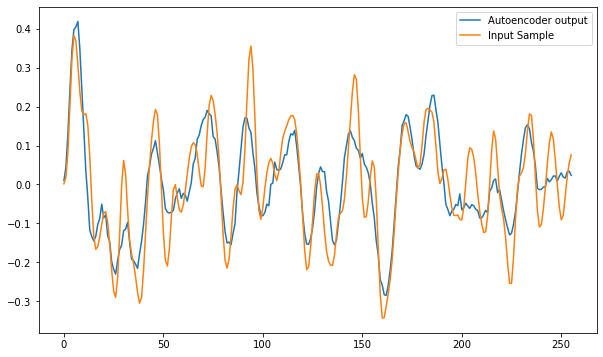

Train Epoch: 51 [0/967 (0%)]	Loss: 34.083809
Train Epoch: 51 [256/967 (26%)]	Loss: 33.998611
Train Epoch: 51 [512/967 (52%)]	Loss: 34.233589
Train Epoch: 51 [768/967 (77%)]	Loss: 33.753147
====> Epoch: 51 Average loss: 33.7648
====> Test set loss: 33.8227
Train Epoch: 52 [0/967 (0%)]	Loss: 33.989037
Train Epoch: 52 [256/967 (26%)]	Loss: 33.911850
Train Epoch: 52 [512/967 (52%)]	Loss: 33.375618
Train Epoch: 52 [768/967 (77%)]	Loss: 33.549515
====> Epoch: 52 Average loss: 33.4181
====> Test set loss: 33.5102
Train Epoch: 53 [0/967 (0%)]	Loss: 33.614803
Train Epoch: 53 [256/967 (26%)]	Loss: 33.493580
Train Epoch: 53 [512/967 (52%)]	Loss: 33.168644
Train Epoch: 53 [768/967 (77%)]	Loss: 33.384708
====> Epoch: 53 Average loss: 33.0834
====> Test set loss: 33.1902
Train Epoch: 54 [0/967 (0%)]	Loss: 33.149273
Train Epoch: 54 [256/967 (26%)]	Loss: 33.190792
Train Epoch: 54 [512/967 (52%)]	Loss: 33.005718
Train Epoch: 54 [768/967 (77%)]	Loss: 32.566036
====> Epoch: 54 Average loss: 32.7532
====>

<Figure size 432x288 with 0 Axes>

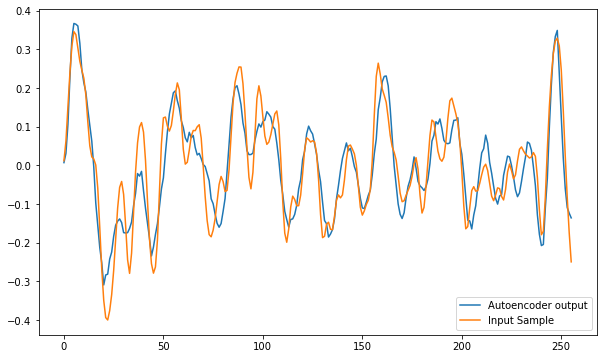

Train Epoch: 101 [0/967 (0%)]	Loss: 24.874149
Train Epoch: 101 [256/967 (26%)]	Loss: 24.451633
Train Epoch: 101 [512/967 (52%)]	Loss: 24.168293
Train Epoch: 101 [768/967 (77%)]	Loss: 24.292839
====> Epoch: 101 Average loss: 24.3066
====> Test set loss: 24.6258
Train Epoch: 102 [0/967 (0%)]	Loss: 24.264019
Train Epoch: 102 [256/967 (26%)]	Loss: 24.394556
Train Epoch: 102 [512/967 (52%)]	Loss: 24.506405
Train Epoch: 102 [768/967 (77%)]	Loss: 23.996737
====> Epoch: 102 Average loss: 24.2431
====> Test set loss: 24.5459
Train Epoch: 103 [0/967 (0%)]	Loss: 24.175076
Train Epoch: 103 [256/967 (26%)]	Loss: 23.698948
Train Epoch: 103 [512/967 (52%)]	Loss: 24.356319
Train Epoch: 103 [768/967 (77%)]	Loss: 24.174696
====> Epoch: 103 Average loss: 24.1686
====> Test set loss: 24.4931
Train Epoch: 104 [0/967 (0%)]	Loss: 23.940205
Train Epoch: 104 [256/967 (26%)]	Loss: 24.118568
Train Epoch: 104 [512/967 (52%)]	Loss: 24.277054
Train Epoch: 104 [768/967 (77%)]	Loss: 23.896568
====> Epoch: 104 Average

<Figure size 432x288 with 0 Axes>

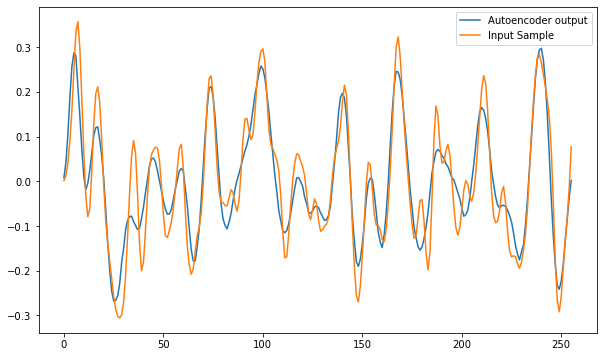

Train Epoch: 151 [0/967 (0%)]	Loss: 19.311581
Train Epoch: 151 [256/967 (26%)]	Loss: 19.448545
Train Epoch: 151 [512/967 (52%)]	Loss: 19.008514
Train Epoch: 151 [768/967 (77%)]	Loss: 19.163443
====> Epoch: 151 Average loss: 19.2759
====> Test set loss: 19.5521
Train Epoch: 152 [0/967 (0%)]	Loss: 19.130104
Train Epoch: 152 [256/967 (26%)]	Loss: 19.022305
Train Epoch: 152 [512/967 (52%)]	Loss: 18.904587
Train Epoch: 152 [768/967 (77%)]	Loss: 19.523020
====> Epoch: 152 Average loss: 19.2229
====> Test set loss: 19.5254
Train Epoch: 153 [0/967 (0%)]	Loss: 19.219110
Train Epoch: 153 [256/967 (26%)]	Loss: 19.197636
Train Epoch: 153 [512/967 (52%)]	Loss: 19.080671
Train Epoch: 153 [768/967 (77%)]	Loss: 19.110968
====> Epoch: 153 Average loss: 19.1813
====> Test set loss: 19.4769
Train Epoch: 154 [0/967 (0%)]	Loss: 19.206997
Train Epoch: 154 [256/967 (26%)]	Loss: 19.236639
Train Epoch: 154 [512/967 (52%)]	Loss: 18.917414
Train Epoch: 154 [768/967 (77%)]	Loss: 18.986355
====> Epoch: 154 Average

<Figure size 432x288 with 0 Axes>

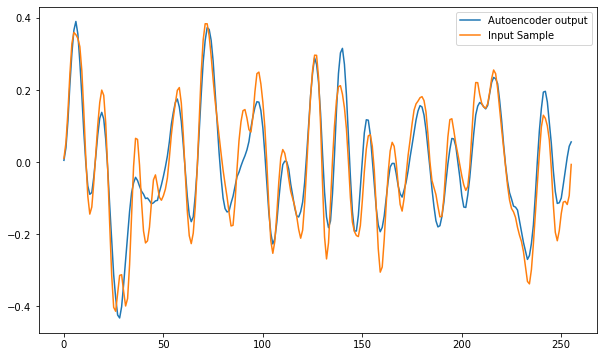

Train Epoch: 201 [0/967 (0%)]	Loss: 16.506626
Train Epoch: 201 [256/967 (26%)]	Loss: 16.323046
Train Epoch: 201 [512/967 (52%)]	Loss: 16.222876
Train Epoch: 201 [768/967 (77%)]	Loss: 16.416451
====> Epoch: 201 Average loss: 16.2252
====> Test set loss: 16.5121
Train Epoch: 202 [0/967 (0%)]	Loss: 16.214737
Train Epoch: 202 [256/967 (26%)]	Loss: 16.024368
Train Epoch: 202 [512/967 (52%)]	Loss: 15.903271
Train Epoch: 202 [768/967 (77%)]	Loss: 15.819910
====> Epoch: 202 Average loss: 16.2034
====> Test set loss: 16.4569
Train Epoch: 203 [0/967 (0%)]	Loss: 16.133339
Train Epoch: 203 [256/967 (26%)]	Loss: 15.869556
Train Epoch: 203 [512/967 (52%)]	Loss: 16.507383
Train Epoch: 203 [768/967 (77%)]	Loss: 16.081942
====> Epoch: 203 Average loss: 16.1823
====> Test set loss: 16.4779
Train Epoch: 204 [0/967 (0%)]	Loss: 16.287554
Train Epoch: 204 [256/967 (26%)]	Loss: 16.121750
Train Epoch: 204 [512/967 (52%)]	Loss: 16.314566
Train Epoch: 204 [768/967 (77%)]	Loss: 15.988456
====> Epoch: 204 Average

<Figure size 432x288 with 0 Axes>

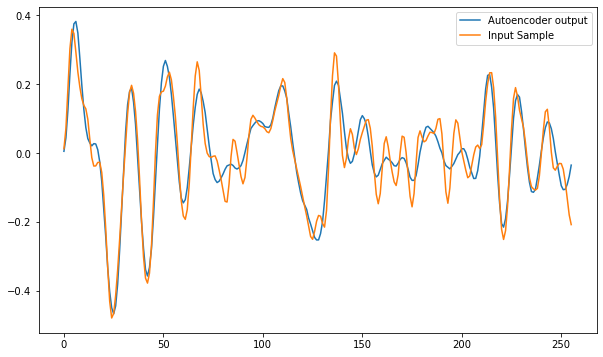

Train Epoch: 251 [0/967 (0%)]	Loss: 15.895113
Train Epoch: 251 [256/967 (26%)]	Loss: 15.938597
Train Epoch: 251 [512/967 (52%)]	Loss: 16.034111
Train Epoch: 251 [768/967 (77%)]	Loss: 15.745275
====> Epoch: 251 Average loss: 15.8695
====> Test set loss: 16.1849
Train Epoch: 252 [0/967 (0%)]	Loss: 15.820274
Train Epoch: 252 [256/967 (26%)]	Loss: 15.914606
Train Epoch: 252 [512/967 (52%)]	Loss: 15.712508
Train Epoch: 252 [768/967 (77%)]	Loss: 15.734983
====> Epoch: 252 Average loss: 15.8643
====> Test set loss: 16.1735
Train Epoch: 253 [0/967 (0%)]	Loss: 15.995764
Train Epoch: 253 [256/967 (26%)]	Loss: 16.037540
Train Epoch: 253 [512/967 (52%)]	Loss: 15.902237
Train Epoch: 253 [768/967 (77%)]	Loss: 15.856587
====> Epoch: 253 Average loss: 15.8589
====> Test set loss: 16.1615
Train Epoch: 254 [0/967 (0%)]	Loss: 15.816408
Train Epoch: 254 [256/967 (26%)]	Loss: 15.816297
Train Epoch: 254 [512/967 (52%)]	Loss: 15.796492
Train Epoch: 254 [768/967 (77%)]	Loss: 15.472004
====> Epoch: 254 Average

<Figure size 432x288 with 0 Axes>

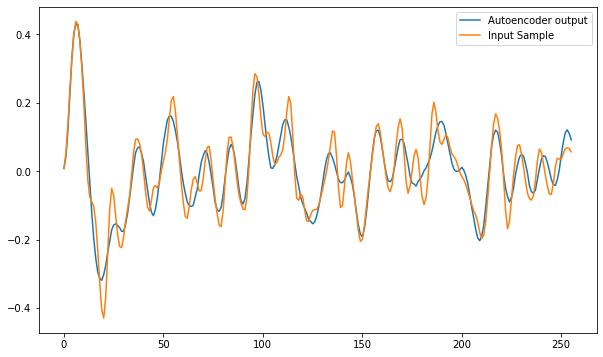

Train Epoch: 301 [0/967 (0%)]	Loss: 15.478712
Train Epoch: 301 [256/967 (26%)]	Loss: 15.265261
Train Epoch: 301 [512/967 (52%)]	Loss: 15.342521
Train Epoch: 301 [768/967 (77%)]	Loss: 15.561148
====> Epoch: 301 Average loss: 15.4296
====> Test set loss: 15.7343
Train Epoch: 302 [0/967 (0%)]	Loss: 15.172332
Train Epoch: 302 [256/967 (26%)]	Loss: 15.849024
Train Epoch: 302 [512/967 (52%)]	Loss: 15.360891
Train Epoch: 302 [768/967 (77%)]	Loss: 15.241273
====> Epoch: 302 Average loss: 15.4061
====> Test set loss: 15.7463
Train Epoch: 303 [0/967 (0%)]	Loss: 15.440491
Train Epoch: 303 [256/967 (26%)]	Loss: 15.252592
Train Epoch: 303 [512/967 (52%)]	Loss: 15.454249
Train Epoch: 303 [768/967 (77%)]	Loss: 15.395306
====> Epoch: 303 Average loss: 15.3926
====> Test set loss: 15.7282
Train Epoch: 304 [0/967 (0%)]	Loss: 15.412985
Train Epoch: 304 [256/967 (26%)]	Loss: 15.178454
Train Epoch: 304 [512/967 (52%)]	Loss: 15.254810
Train Epoch: 304 [768/967 (77%)]	Loss: 15.383353
====> Epoch: 304 Average

<Figure size 432x288 with 0 Axes>

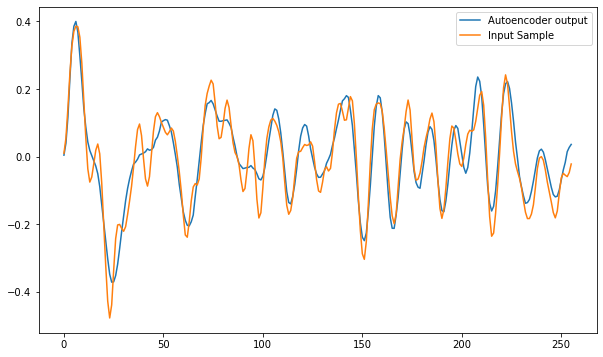

Train Epoch: 351 [0/967 (0%)]	Loss: 14.634041
Train Epoch: 351 [256/967 (26%)]	Loss: 14.661823
Train Epoch: 351 [512/967 (52%)]	Loss: 14.826178
Train Epoch: 351 [768/967 (77%)]	Loss: 15.025096
====> Epoch: 351 Average loss: 14.8183
====> Test set loss: 15.1602
Train Epoch: 352 [0/967 (0%)]	Loss: 14.885725
Train Epoch: 352 [256/967 (26%)]	Loss: 14.668693
Train Epoch: 352 [512/967 (52%)]	Loss: 14.848438
Train Epoch: 352 [768/967 (77%)]	Loss: 14.746712
====> Epoch: 352 Average loss: 14.8151
====> Test set loss: 15.1350
Train Epoch: 353 [0/967 (0%)]	Loss: 14.732977
Train Epoch: 353 [256/967 (26%)]	Loss: 14.710915
Train Epoch: 353 [512/967 (52%)]	Loss: 14.819555
Train Epoch: 353 [768/967 (77%)]	Loss: 14.581594
====> Epoch: 353 Average loss: 14.8055
====> Test set loss: 15.1512
Train Epoch: 354 [0/967 (0%)]	Loss: 14.854349
Train Epoch: 354 [256/967 (26%)]	Loss: 15.048836
Train Epoch: 354 [512/967 (52%)]	Loss: 14.754965
Train Epoch: 354 [768/967 (77%)]	Loss: 14.742372
====> Epoch: 354 Average

<Figure size 432x288 with 0 Axes>

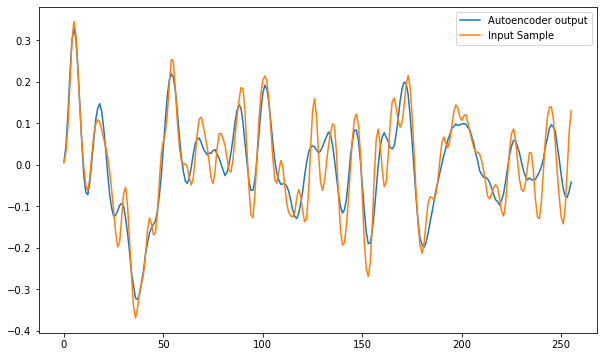

In [16]:
# Train the Autoencoder on our EEG data!
for epoch in range(1, EPOCHS+1):
    train(epoch)
    test(epoch)
    if epoch % EPOCHS_INTERVAL == 0:
        with torch.no_grad():
            plt.figure()
            plt.figure(figsize=(10,6))
            sample = full_dataset[random.randint(0,len(full_dataset))]
            x= model.encode(torch.from_numpy(sample).cuda()) 
            out = model.decode(x)
            out = out.cpu().detach().numpy()

            plt.plot(out[5], label='Autoencoder output') 
            plt.plot(sample[5], label='Input Sample')
            plt.legend()
            plt.show()

In [17]:
# Save the trained
torch.save(model.state_dict(), 'Autoencoder_RandomData_Linear.pt')

In [18]:
# Load a trained model
model = Autoencoder(AE_PARAMS)
model.load_state_dict(torch.load('Autoencoder_RandomData_Linear.pt'))
model.eval()

# Push it onto the GPU
model.cuda()

Autoencoder(
  (fc1): Linear(in_features=256, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=40, bias=True)
  (fc4): Linear(in_features=40, out_features=64, bias=True)
  (fc5): Linear(in_features=64, out_features=128, bias=True)
  (fc6): Linear(in_features=128, out_features=256, bias=True)
)

<Figure size 432x288 with 0 Axes>

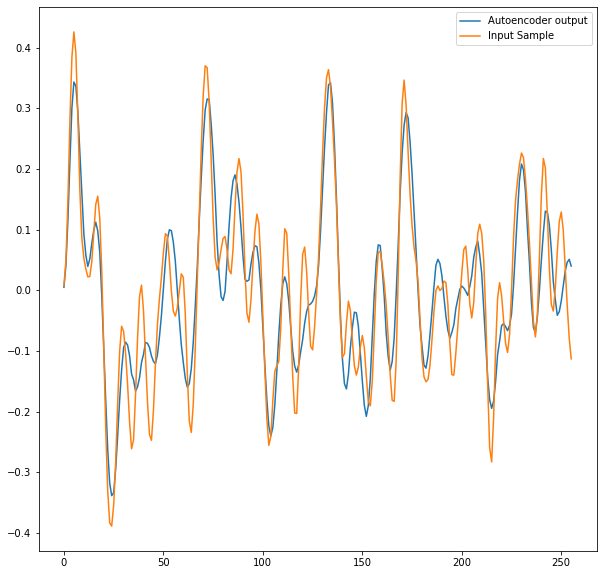

In [19]:
# Test the loaded model
with torch.no_grad():
    plt.figure()
    plt.figure(figsize=(10,10))
    sample = full_dataset[random.randint(0,len(full_dataset))]
    x= model.encode(torch.from_numpy(sample).cuda()) 
    out = model.decode(x)
    out = out.cpu().detach().numpy()

    plt.plot(out[4], label='Autoencoder output') 
    plt.plot(sample[4], label='Input Sample')
    plt.legend()
    plt.show()

====> Test set loss: 15.0116


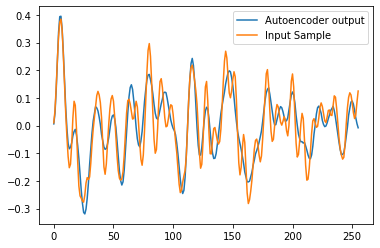

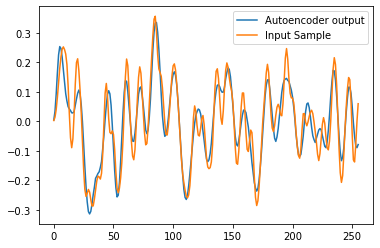

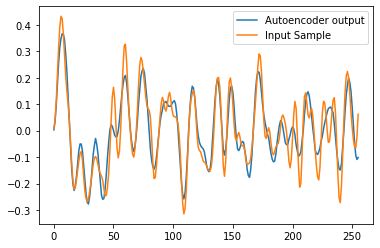

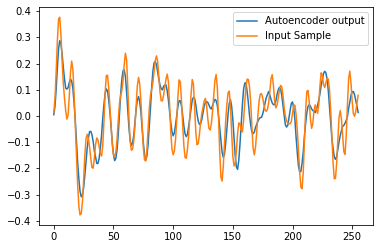

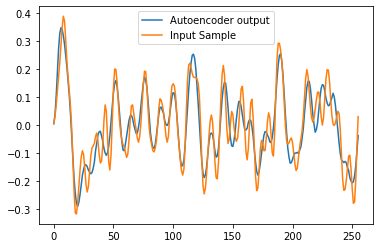

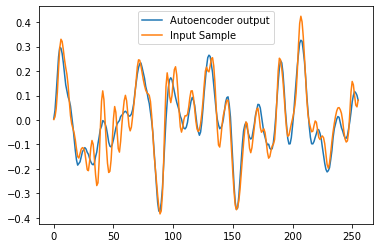

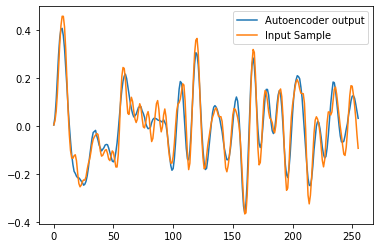

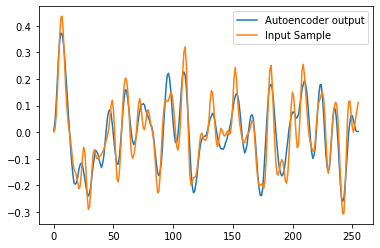

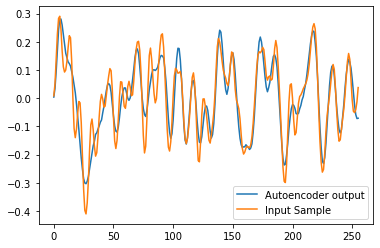

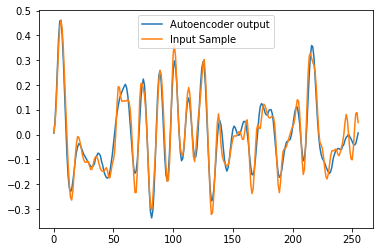

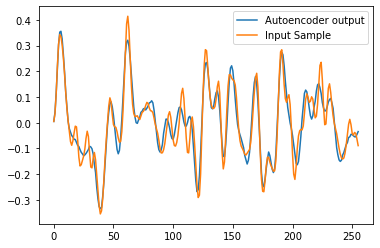

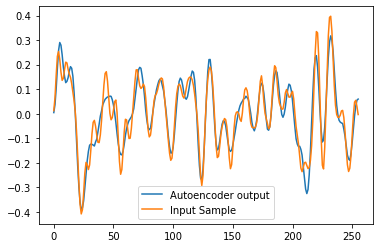

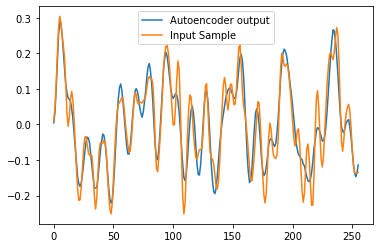

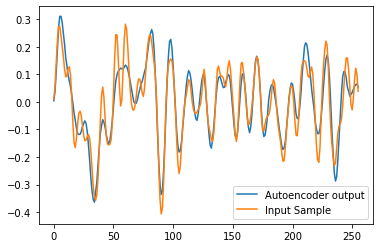

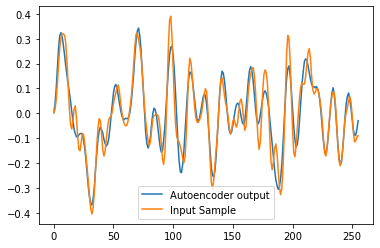

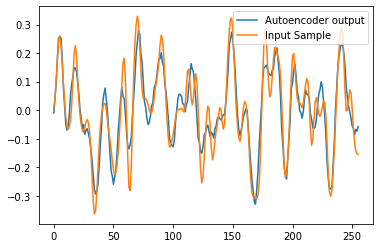

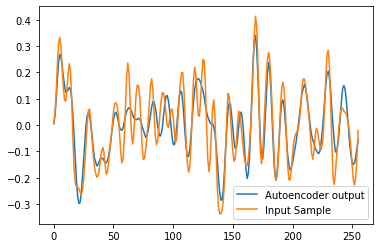

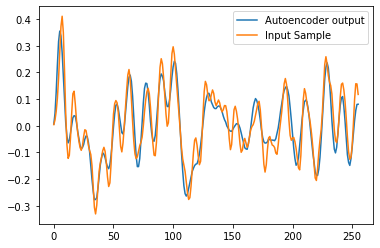

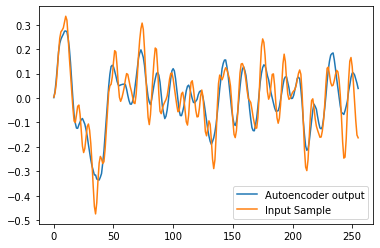

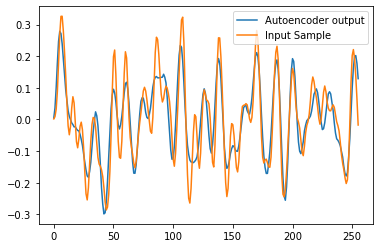

In [20]:
test(0)

with torch.no_grad():
        plt.figure()
        sample = test_dataset[random.randint(0, len(test_dataset))]
        x= model.encode(torch.from_numpy(sample).cuda()) 
        out = model.decode(x)
        out = out.cpu().detach().numpy()

        for chan in range(0, channelNum):
                plt.plot(out[chan], label='Autoencoder output') 
                plt.plot(sample[chan], label='Input Sample')
                plt.legend()
                plt.show()
